 Prepare the general libraries.

In [1]:
# libraries
library(community)
library(ggplot2)

 Prepare the path.

In [2]:
# the path to the counts, cell annotation and sample annation file. In this case its our working dir same as
# the notebook
path_in <- 'computed_results/'

print("path_in")
print(path_in)

[1] "path_in"
[1] "computed_results/"


Load data.

In [3]:
suppressWarnings(load(paste0(path_in,"/interactions.RData")))

Load functions for visualization.

In [4]:
data("visualization_functions")

## Parameters

In [5]:
# threshold for log2FC of the weights
threshold_log2FC <- interactions$thresholds$threshold_log2FC

idx_up <- interactions$anno_interactions$log2FC_weights > threshold_log2FC
idx_unchanged <- abs(interactions$anno_interactions$log2FC_weights)<= threshold_log2FC
idx_down <- interactions$anno_interactions$log2FC_weights < -threshold_log2FC
idx_sign <- !is.na(interactions$anno_interactions$sign) & interactions$anno_interactions$sign
idx_good <- interactions$anno_interactions$passed_QC_filter

In [6]:
# extract cell types
cell_types <- unique(interactions$anno_cells$cell_type)
print(cell_types)

[1] "Mono" "Gran" "T"    "NK"   "B"    "HSPC" "Ery"  "DC"  


In [7]:
# define broad type of interactions by cell types
immune_cell_types <- cell_types[!(cell_types %in% c("Ery","HSPC"))]

interaction_cell_types <- unique(paste(interactions$anno_interactions$sending_cell_type
                                ,interactions$anno_interactions$receiving_cell_type
                                ,sep = " to "))

interaction_type <- sapply(interaction_cell_types
                           ,function(i){
                               ifelse(grepl("Ery",i)
                                      ,"engages Ery"
                                      ,ifelse(grepl("HSPC",i)
                                              ,"engages HSPC"
                                              ,"among immune cells"))
                           })
print(str(interaction_type))

interaction_type_by_ID <- sapply(interactions$anno_interactions$interaction_ID
                           ,function(i){
                               ifelse(grepl("Ery",i)
                                      ,"engages Ery"
                                      ,ifelse(grepl("HSPC",i)
                                              ,"engages HSPC"
                                              ,"among immune cells"))
                           })
print(str(interaction_type_by_ID))

colors_interaction_type <- c("engages HSPC" = "magenta"
                             ,"among immune cells" = "deepskyblue"
                             ,"engages Ery" = "darkgoldenrod3"#"lightgoldenrod"
                            )
print(colors_interaction_type)

 Named chr [1:64] "among immune cells" "among immune cells" ...
 - attr(*, "names")= chr [1:64] "Mono to Mono" "Mono to Gran" "Mono to T" "Mono to NK" ...
NULL
 Named chr [1:151744] "among immune cells" "among immune cells" ...
 - attr(*, "names")= chr [1:151744] "Mono:JAG2_Mono:NOTCH1" "Mono:DLL1_Mono:NOTCH1" "Mono:IGF1_Mono:IGF1R" "Mono:JAG1_Mono:NOTCH1" ...
NULL
      engages HSPC among immune cells        engages Ery 
         "magenta"      "deepskyblue"   "darkgoldenrod3" 


## Visualization: all good quality interactions

### Mean weight vs mean number 

In [8]:
library(ggrepel) # to add text labels on the mean weigth vs number of interactions plot

In [9]:
# claclulate mean weight of good interactions for each cell type to cell type communication (i.e. "T to B", "DC to T")
mean_weights_goodInteractions <- mean_weights(interactions)

print(str(mean_weights_goodInteractions))

List of 2
 $ AML    :'data.frame':	8 obs. of  8 variables:
  ..$ Mono: num [1:8] 0.0315 0.03132 0.00935 0.00737 0.00484 ...
  ..$ Gran: num [1:8] 0.0304 0.04296 0.01019 0.00703 0.01527 ...
  ..$ T   : num [1:8] 0.00871 0.01307 0.06822 0.05788 0.0185 ...
  ..$ NK  : num [1:8] 0.00703 0.00884 0.05729 0.05555 0.01199 ...
  ..$ B   : num [1:8] 0.00401 0.01554 0.01711 0.01125 0.0164 ...
  ..$ HSPC: num [1:8] 0.00931 0.02336 0.02182 0.01402 0.02106 ...
  ..$ Ery : num [1:8] 0.00117 0.00525 0.00709 0.00273 0.00698 ...
  ..$ DC  : num [1:8] 0.01015 0.01562 0.02284 0.02079 0.00564 ...
 $ healthy:'data.frame':	8 obs. of  8 variables:
  ..$ Mono: num [1:8] 0.023 0.0364 0.0187 0.0175 0.0216 ...
  ..$ Gran: num [1:8] 0.0331 0.0608 0.0266 0.0222 0.0339 ...
  ..$ T   : num [1:8] 0.0214 0.0315 0.0292 0.0201 0.0283 ...
  ..$ NK  : num [1:8] 0.019 0.0242 0.0195 0.0167 0.017 ...
  ..$ B   : num [1:8] 0.023 0.0388 0.026 0.0157 0.0453 ...
  ..$ HSPC: num [1:8] 0.00548 0.00899 0.00435 0.00378 0.00516 ...
  

In [10]:
# claclulate number of good interactions for each cell type to cell type communication (i.e. "T to B", "DC to T")
number_goodInteractions <- number_interactions(interactions)

print(str(number_goodInteractions))

List of 2
 $ AML    :'data.frame':	8 obs. of  8 variables:
  ..$ Mono: int [1:8] 837 617 579 410 445 502 188 556
  ..$ Gran: int [1:8] 632 472 457 314 362 411 271 437
  ..$ T   : int [1:8] 579 442 498 347 389 422 263 454
  ..$ NK  : int [1:8] 364 281 295 224 225 253 92 283
  ..$ B   : int [1:8] 341 276 293 194 225 256 166 266
  ..$ HSPC: int [1:8] 459 359 405 254 308 409 238 322
  ..$ Ery : int [1:8] 136 209 210 76 186 219 165 123
  ..$ DC  : int [1:8] 547 405 421 296 313 338 132 416
 $ healthy:'data.frame':	8 obs. of  8 variables:
  ..$ Mono: int [1:8] 838 618 599 421 467 501 191 602
  ..$ Gran: int [1:8] 638 478 470 333 370 415 275 476
  ..$ T   : int [1:8] 601 452 498 347 393 423 263 477
  ..$ NK  : int [1:8] 371 289 295 224 228 255 94 296
  ..$ B   : int [1:8] 350 281 294 197 225 254 166 283
  ..$ HSPC: int [1:8] 447 361 396 256 300 385 238 342
  ..$ Ery : int [1:8] 145 220 211 76 186 219 165 166
  ..$ DC  : int [1:8] 615 468 449 320 348 367 181 467
NULL


In [11]:
immune_cell_types <- cell_types[!(cell_types %in% c("Ery","HSPC"))]
grepl(paste(immune_cell_types, collapse="|"), "B cell")

[1] TRUE

'data.frame':	64 obs. of  4 variables:
 $ mean_interaction_weight: num  0.0315 0.03132 0.00935 0.00737 0.00484 ...
 $ number_of_interactions : int  837 617 579 410 445 502 188 556 632 472 ...
 $ interaction_ID         : chr  "Mono to Mono" "Gran to Mono" "T to Mono" "NK to Mono" ...
 $ interaction_type       : chr  "among immune cells" "among immune cells" "among immune cells" "among immune cells" ...
NULL
'data.frame':	64 obs. of  4 variables:
 $ mean_interaction_weight: num  0.023 0.0364 0.0187 0.0175 0.0216 ...
 $ number_of_interactions : int  838 618 599 421 467 501 191 602 638 478 ...
 $ interaction_ID         : chr  "Mono to Mono" "Gran to Mono" "T to Mono" "NK to Mono" ...
 $ interaction_type       : chr  "among immune cells" "among immune cells" "among immune cells" "among immune cells" ...
NULL


Warning message:
“Removed 1 rows containing non-finite values (`stat_ellipse()`).”
Warning message:
“Removed 1 rows containing missing values (`geom_point()`).”
Warning message:
“Removed 1 rows containing missing values (`geom_text_repel()`).”
Warning message:
“ggrepel: 53 unlabeled data points (too many overlaps). Consider increasing max.overlaps”
Warning message:
“Removed 1 rows containing non-finite values (`stat_ellipse()`).”
Warning message:
“Removed 1 rows containing missing values (`geom_point()`).”
Warning message:
“Removed 1 rows containing missing values (`geom_text_repel()`).”
Warning message:
“ggrepel: 59 unlabeled data points (too many overlaps). Consider increasing max.overlaps”


[[1]]

[[2]]


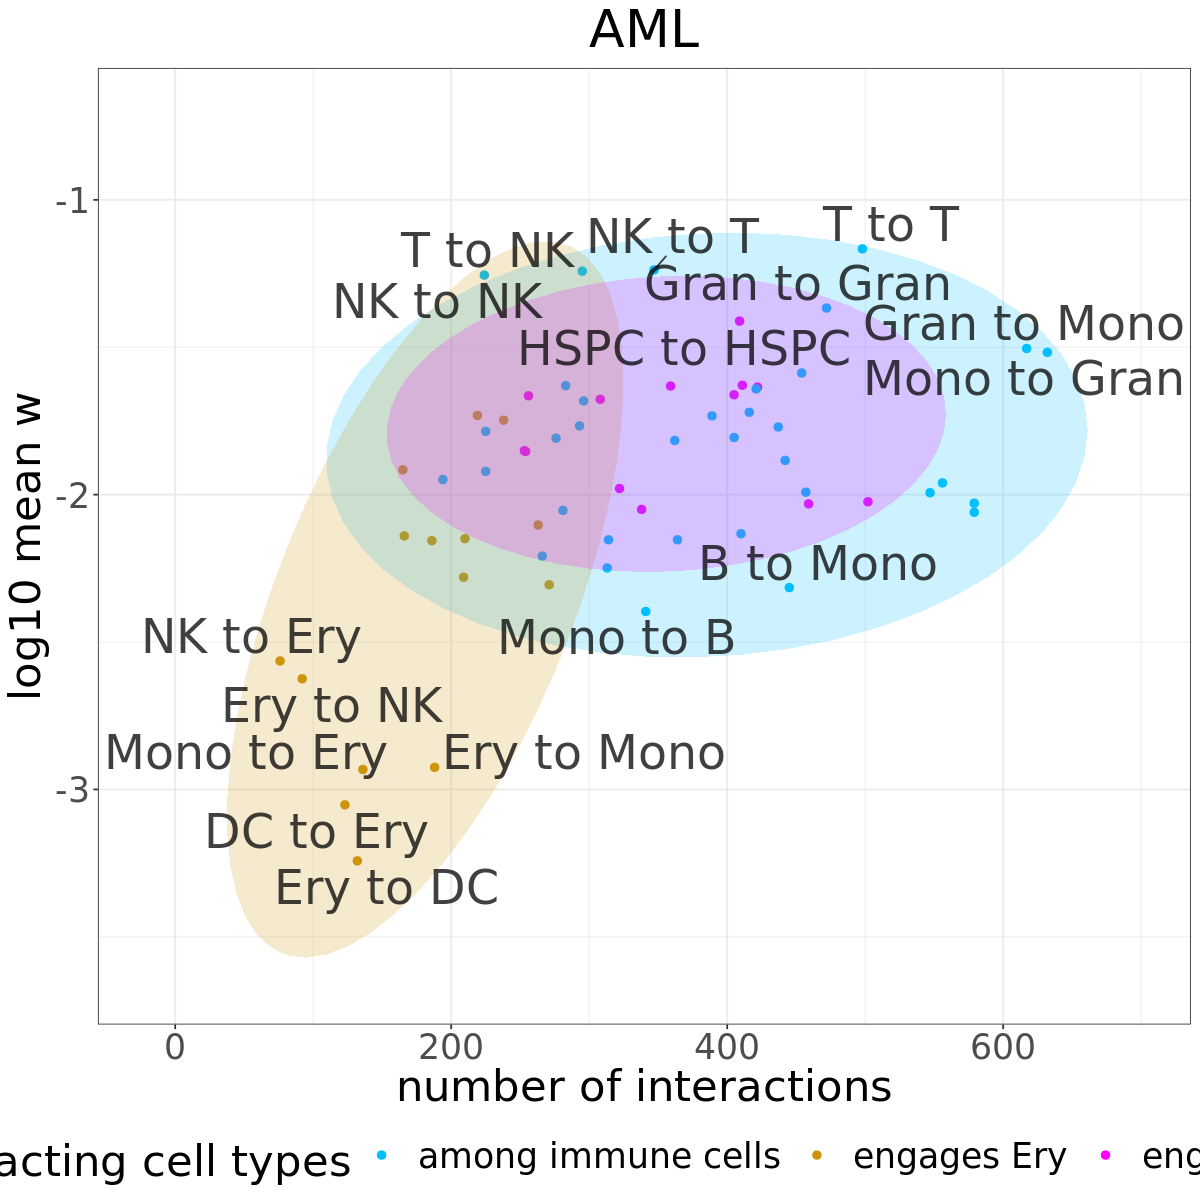

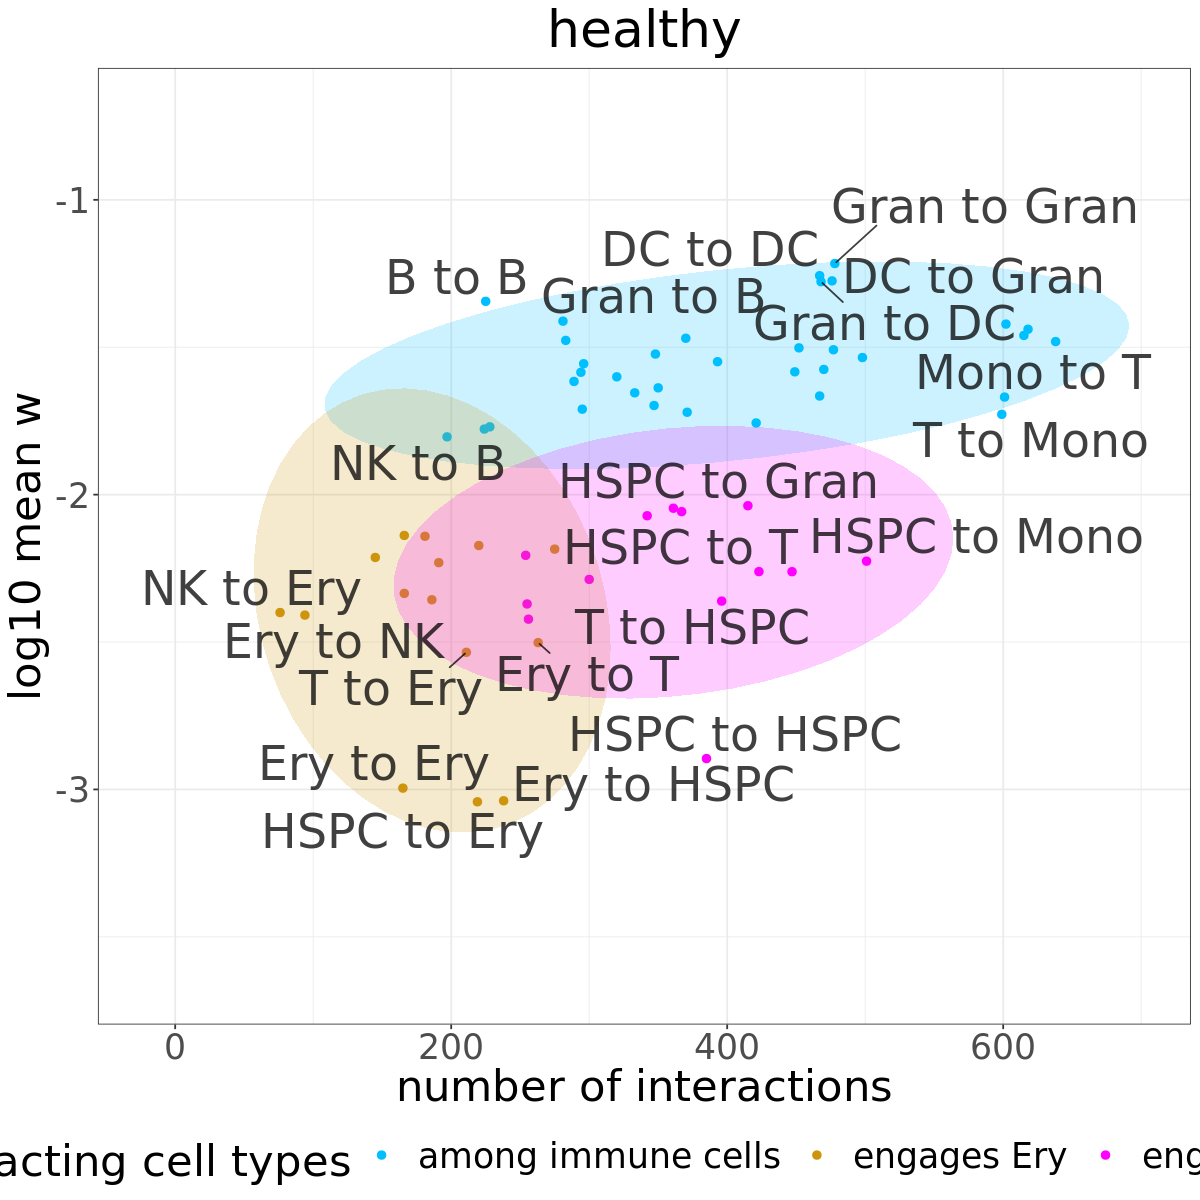

In [12]:
# plot mumber of interactions vs mean interaction weights per cell type to cell type interaction
options(repr.plot.width = 10
        ,repr.plot.height = 10)

ylim <- c(-3.65, -0.7)
xlim <- c(-20, 700)

plot_nrInt_vs_meanW_perCellType(interactions
                               ,interaction_type = interaction_type
                               ,colors = colors_interaction_type
                               ,ylim = ylim
                               ,label_font_size = 10)

## Visualization of differential interactions

### Voclano

In [13]:
print("downregulated:")
print(sum(idx_down & idx_sign))

print("upregulated:")
print(sum(idx_up & idx_sign))

[1] "downregulated:"
[1] 2555
[1] "upregulated:"
[1] 109


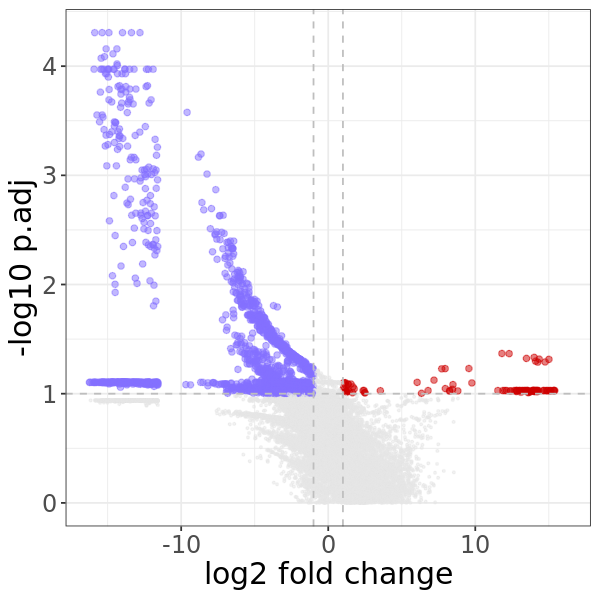

In [14]:
# volcano plot
options(repr.plot.height = 5
       ,repr.plot.width = 5)
    
plot_vulcano(interactions)

### Heatmap top differential

In [15]:
library(ComplexHeatmap) # to plot heatmaps
library(circlize) # for gragient colors

Loading required package: grid

ComplexHeatmap version 2.10.0
Bioconductor page: http://bioconductor.org/packages/ComplexHeatmap/
Github page: https://github.com/jokergoo/ComplexHeatmap
Documentation: http://jokergoo.github.io/ComplexHeatmap-reference

If you use it in published research, please cite:
Gu, Z. Complex heatmaps reveal patterns and correlations in multidimensional 
  genomic data. Bioinformatics 2016.

The new InteractiveComplexHeatmap package can directly export static 
complex heatmaps into an interactive Shiny app with zero effort. Have a try!

This message can be suppressed by:
  suppressPackageStartupMessages(library(ComplexHeatmap))


Warning message:
“package ‘circlize’ was built under R version 4.1.3”
circlize version 0.4.15
CRAN page: https://cran.r-project.org/package=circlize
Github page: https://github.com/jokergoo/circlize
Documentation: https://jokergoo.github.io/circlize_book/book/

If you use it in published research, please cite:
Gu, Z. circlize implements

In [16]:
# heatmap of interactions weight of top differential interactions
# top adjusted p value
idx_topsign <- interactions$anno_interactions$p.adj %in% unique(sort(interactions$anno_interactions$p.adj))[1:300]
idx_topdown <- interactions$anno_interactions$log2FC_weights < -1 & idx_topsign
idx_topdown <- interactions$anno_interactions$interaction_ID %in% interactions$anno_interactions$interaction_ID[idx_topdown][1:10]

# all upregulated interactions
idx_topsign <- interactions$anno_interactions$p.adj %in% unique(sort(interactions$anno_interactions$p.adj))[1:500]
idx_topup <- interactions$anno_interactions$log2FC_weights > 1 & idx_topsign
idx_topup <- interactions$anno_interactions$interaction_ID %in% interactions$anno_interactions$interaction_ID[idx_topup][1:9]

idx <- idx_topup | idx_topdown

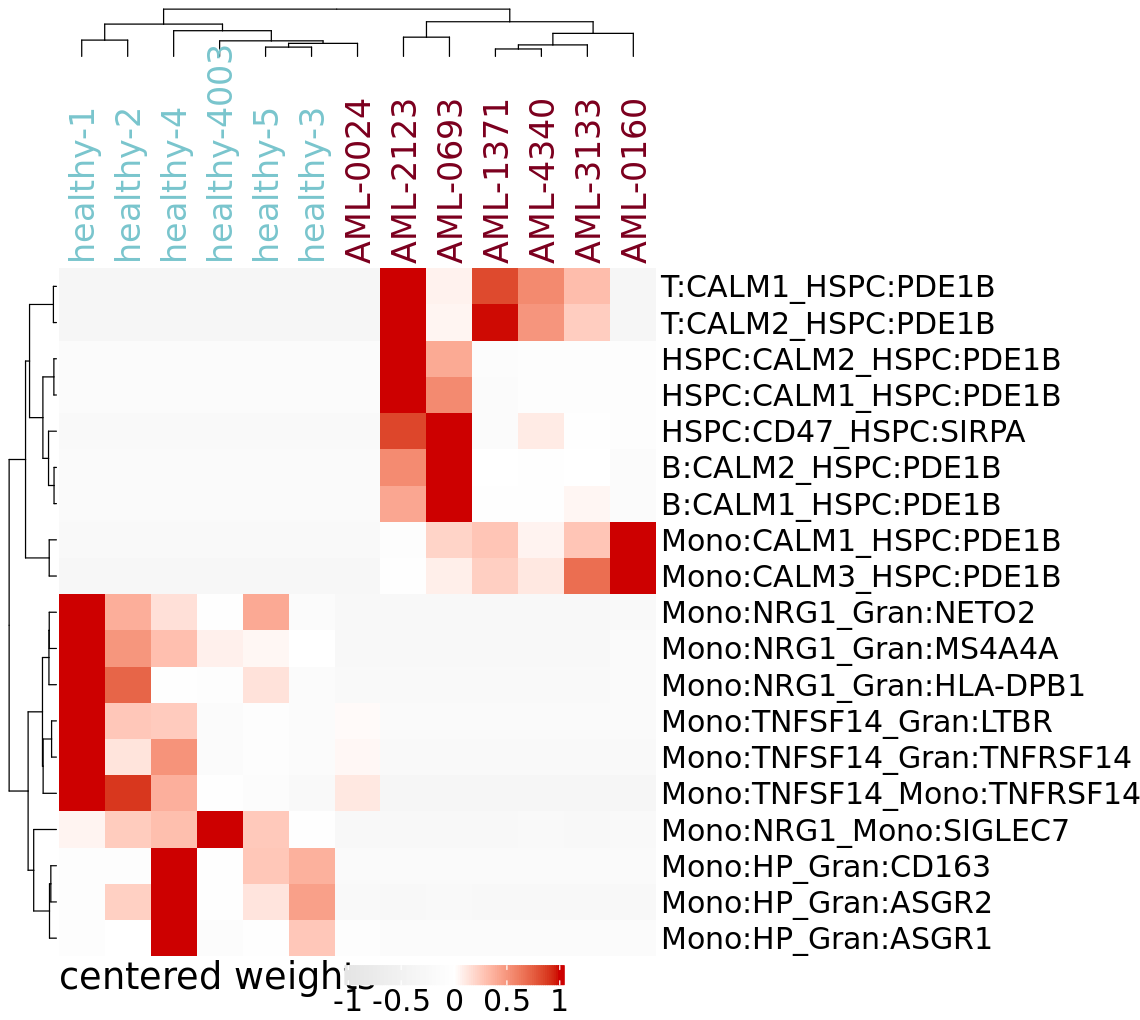

In [17]:
# centred Heatmap
set.seed(3)
options(repr.plot.height = 8.5
       ,repr.plot.width = 9.5
       )
plot_heatmap(interactions
            ,which_interactions = idx
            ,values_to_plot = "weights"
            ,row_font_size =18
            ,column_font_size = 20
             ,centered = TRUE
             ,color_values = circlize::colorRamp2(c(-1,0,1), c("gray90","white", "red3"))
             ,legend_title_font_size = 22
             ,labels_font_size = 18
            )

### Network plots

In [18]:
library(igraph) # to plot circus plots


Attaching package: ‘igraph’


The following object is masked from ‘package:circlize’:

    degree


The following objects are masked from ‘package:stats’:

    decompose, spectrum


The following object is masked from ‘package:base’:

    union




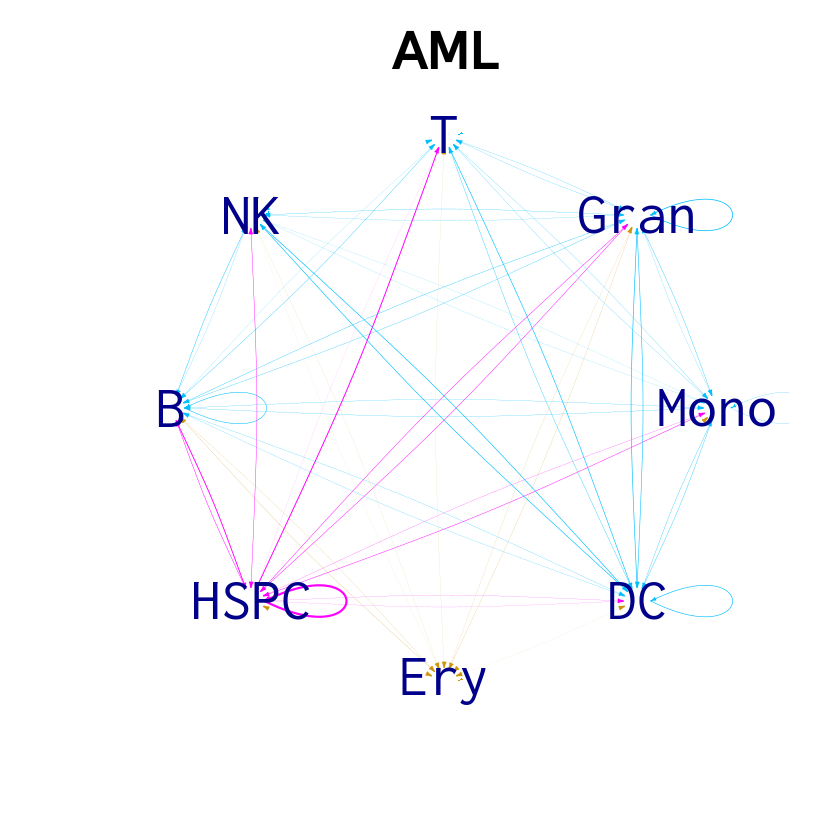

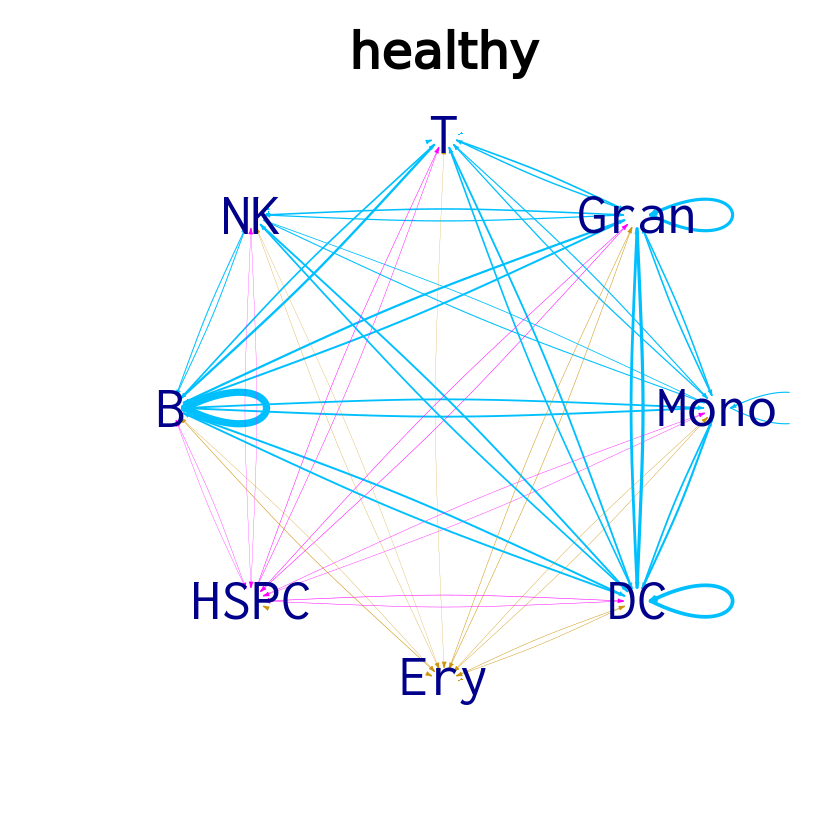

In [19]:
options(repr.plot.width = 7
       ,repr.plot.height = 7)

colors <- colors_interaction_type[interaction_type]
names(colors) <- names(interaction_type)

plor_celltype_network(interactions
                     ,edge.color = colors
                     ,title_cex = 2.5
                     ,vertex.label.cex = 3
                     ,edge.arrow.size = 0.2
                     ,verbose = FALSE
                     )

## Visualization of individual components

<img src="../components_scheme.png">

### Forest plots

In [20]:
library(gridExtra) 

Warning message:
“package ‘gridExtra’ was built under R version 4.1.3”


In [21]:
ordered_IDs <- order_IDs_by_interaction_categories(interactions)
print(str(ordered_IDs))
print(length(unlist(ordered_IDs)))

List of 34
 $ ID_order_no_change                       : chr [1:3405] "Mono:TP53_Mono:TNFRSF10D" "Mono:TNFSF10_Mono:TNFRSF10D" "Mono:TYK2_Mono:IFNAR1" "Mono:TYK2_Mono:IFNAR2" ...
 $ ID_order_rho_s_only_down                 : chr [1:62] "DC:HLA-C_Mono:NOTCH4" "DC:CD99_Mono:CD99L2" "DC:FAM3C_Mono:FFAR2" "DC:PTDSS1_Mono:SCARB1" ...
 $ ID_order_phi_s_only_down                 : chr [1:163] "Mono:TNFSF14_Mono:LTBR" "Mono:TNFSF14_Mono:TNFRSF14" "Mono:HP_Mono:ITGAM" "Mono:HP_Mono:ITGB2" ...
 $ ID_order_p_s_only_down                   : chr [1:4] "Gran:SIRPB2_NK:CD47" "NK:COL6A2_Gran:ITGAV" "NK:HRAS_Gran:INSR" "NK:HRAS_Gran:TLR2"
 $ ID_order_rho_r_only_down                 : chr [1:76] "Mono:TNF_DC:TNFRSF1B" "Mono:AFDN_DC:NECTIN1" "Mono:GDF11_DC:BMPR2" "Mono:THBS1_DC:ITGA4" ...
 $ ID_order_phi_r_only_down                 : chr [1:206] "Mono:CAMP_Mono:FPR2" "Mono:CD48_Mono:CD2" "Mono:CD58_Mono:CD2" "Mono:VEGFA_Mono:NRP1" ...
 $ ID_order_p_r_only_down                   : chr [1:5] "Mono:TNF_NK:R

#### Split by category

In [22]:
component_lim <- find_component_limits(interactions, ordered_IDs)

print(str(component_lim))

List of 14
 $ log2FC_w_min    : num -16.2
 $ log2FC_w_max    : num 15.4
 $ log2FC_rho_s_min: num -1.37
 $ log2FC_rho_s_max: num 2.18
 $ log2FC_phi_s_min: num -6.44
 $ log2FC_phi_s_max: num 5.69
 $ log2FC_p_s_min  : num -4.22
 $ log2FC_p_s_max  : num 1.1
 $ log2FC_rho_r_min: num -1.37
 $ log2FC_rho_r_max: num 2.18
 $ log2FC_phi_r_min: num -6.5
 $ log2FC_phi_r_max: num 5.65
 $ log2FC_p_r_min  : num -2.29
 $ log2FC_p_r_max  : num 1.14
NULL


In [23]:
forestplot_for_category <- function(IDs){
    # revert
    IDs <- IDs[length(IDs):1]
    
    rownames(interactions$anno_interactions) <- interactions$anno_interactions$interaction_ID
    my_anno_interactions <- interactions$anno_interactions[IDs,]
    my_anno_interactions$interaction_ID <- factor(my_anno_interactions$interaction_ID
                                                 ,ordered = TRUE
                                                        )
    
    print(paste(nrow(my_anno_interactions), "interactions in this category"))
    
    plot_all_forests(my_idx = rep(TRUE,nrow(my_anno_interactions))
                     ,my_anno_interactions = my_anno_interactions
                     ,keep_order = TRUE
                     ,threshold = 1
                     ,legend_title_size = 0
                     ,legend_text_size = 20
                     ,component_lim = component_lim
                    )
}

[1] "3405 interactions in this category"


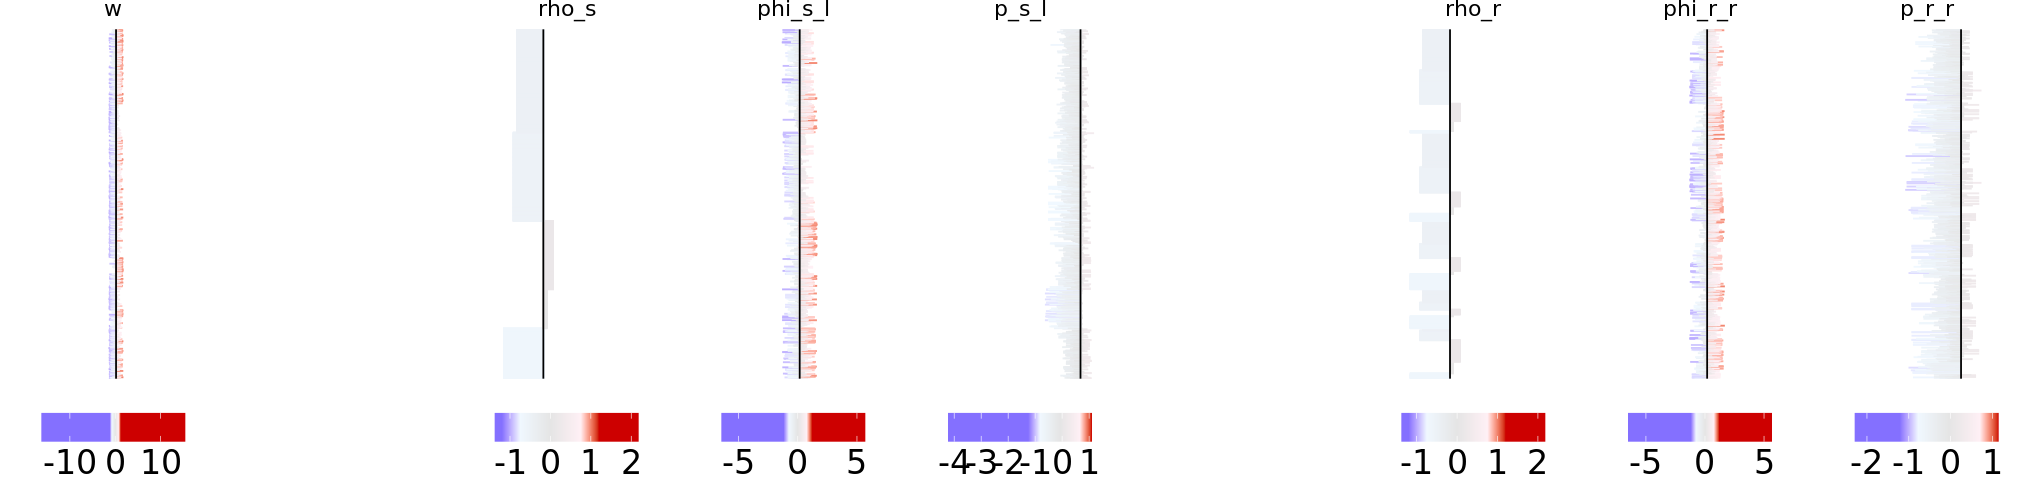

In [24]:
options(repr.plot.width = 17
       ,repr.plot.height = 4)

IDs <- as.character(c(ordered_IDs$ID_order_no_change))
forestplot_for_category(IDs)

[1] "516 interactions in this category"


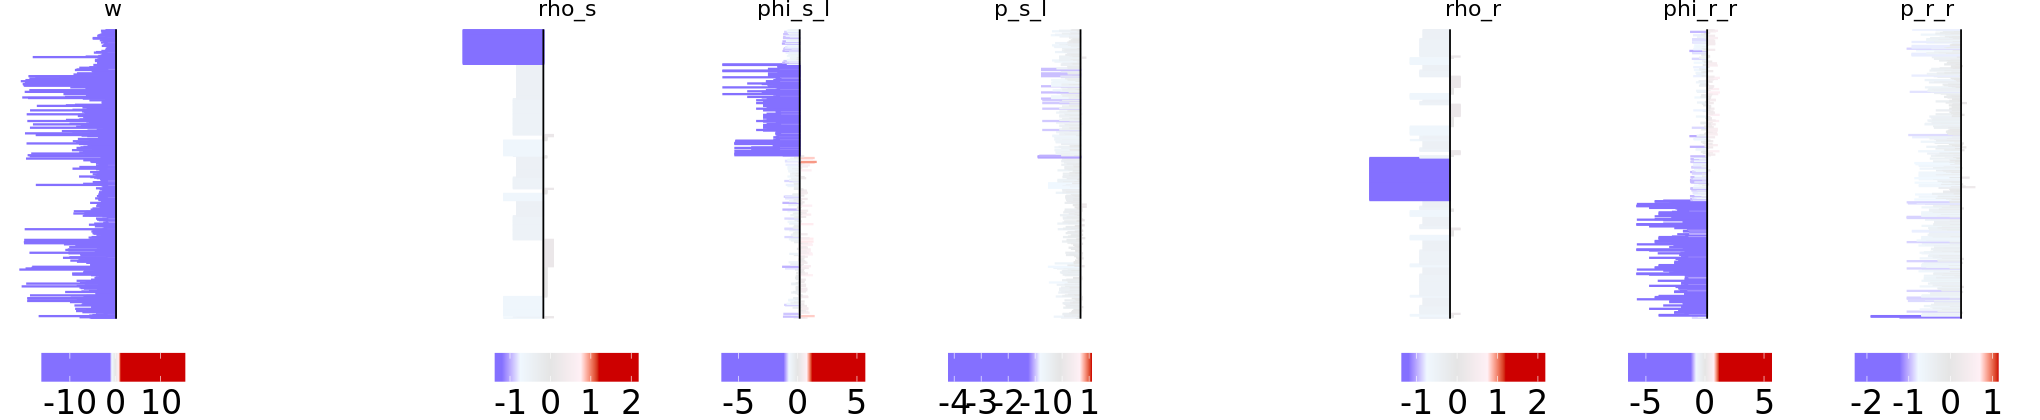

In [25]:
options(repr.plot.width = 17
       ,repr.plot.height = 3.5
       )

IDs <- as.character(c(ordered_IDs$ID_order_rho_s_only_down
                         ,ordered_IDs$ID_order_phi_s_only_down
                         ,ordered_IDs$ID_order_p_s_only_down
                         ,ordered_IDs$ID_order_rho_r_only_down
                         ,ordered_IDs$ID_order_phi_r_only_down
                         ,ordered_IDs$ID_order_p_r_only_down
                     ))

forestplot_for_category(IDs)

[1] "1 interactions in this category"


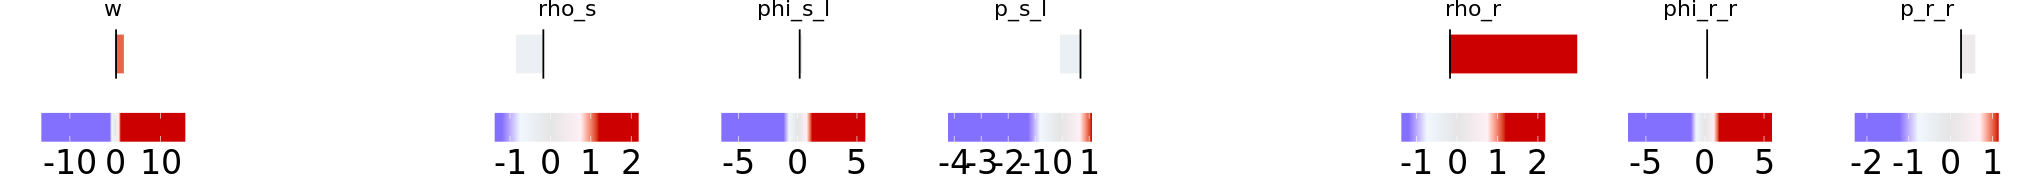

In [26]:
options(repr.plot.width = 17
       ,repr.plot.height = 1.5)

IDs <- as.character(c(ordered_IDs$ID_order_rho_s_only_up
                          ,ordered_IDs$ID_order_phi_s_only_up
                          ,ordered_IDs$ID_order_p_s_only_up
                          ,ordered_IDs$ID_order_rho_r_only_up
                          ,ordered_IDs$ID_order_phi_r_only_up
                          ,ordered_IDs$ID_order_p_r_only_up
                     ))

forestplot_for_category(IDs)

[1] "1060 interactions in this category"


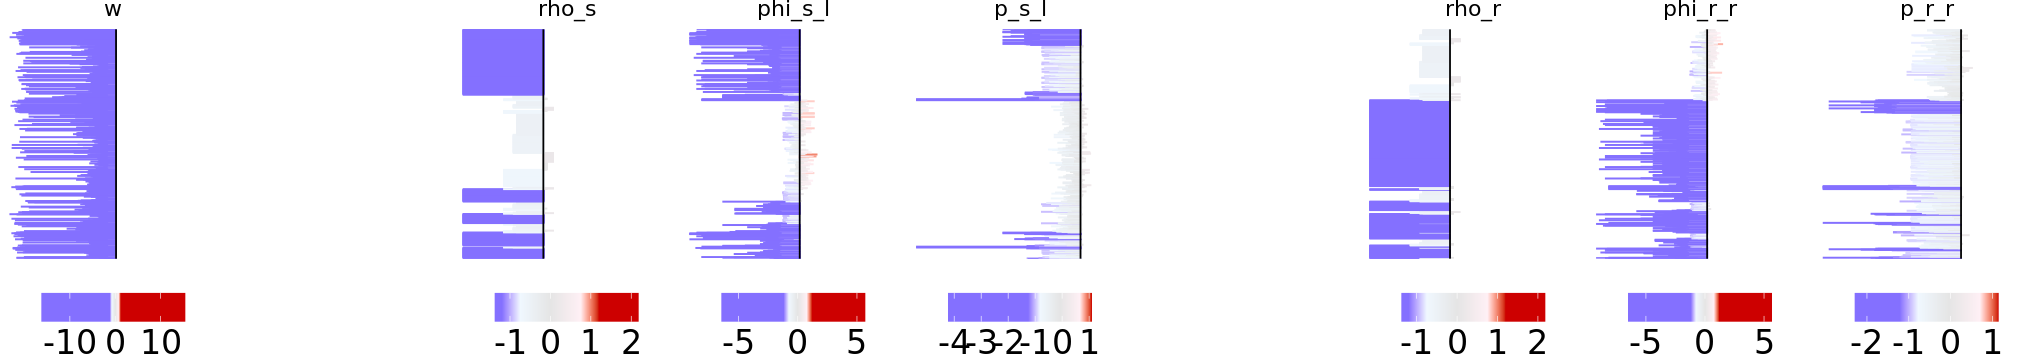

In [27]:
options(repr.plot.width = 17
       ,repr.plot.height = 3)

IDs <- as.character(c(ordered_IDs$ID_order_concordantDown_s
                          ,ordered_IDs$ID_order_concordantDown_r
                          ,ordered_IDs$ID_order_concordantDown_b_one_one
                          ,ordered_IDs$ID_order_concordantDown_b_one_several
                          ,ordered_IDs$ID_order_concordantDown_b_several_one
                          ,ordered_IDs$ID_order_concordantDown_b_several_several
                     ))

forestplot_for_category(IDs)

[1] "79 interactions in this category"


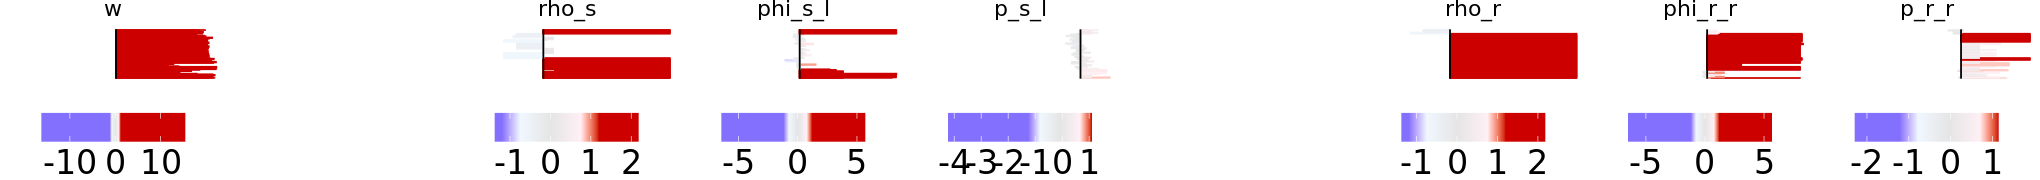

In [28]:
options(repr.plot.width = 17
       ,repr.plot.height = 1.5)

IDs <- as.character(c(ordered_IDs$ID_order_concordantUp_s
                          ,ordered_IDs$ID_order_concordantUp_r
                          ,ordered_IDs$ID_order_concordantUp_b_one_one
                          ,ordered_IDs$ID_order_concordantUp_b_one_several
                          ,ordered_IDs$ID_order_concordantUp_b_several_one
                          ,ordered_IDs$ID_order_concordantUp_b_several_several
                     ))

forestplot_for_category(IDs)

[1] "675 interactions in this category"


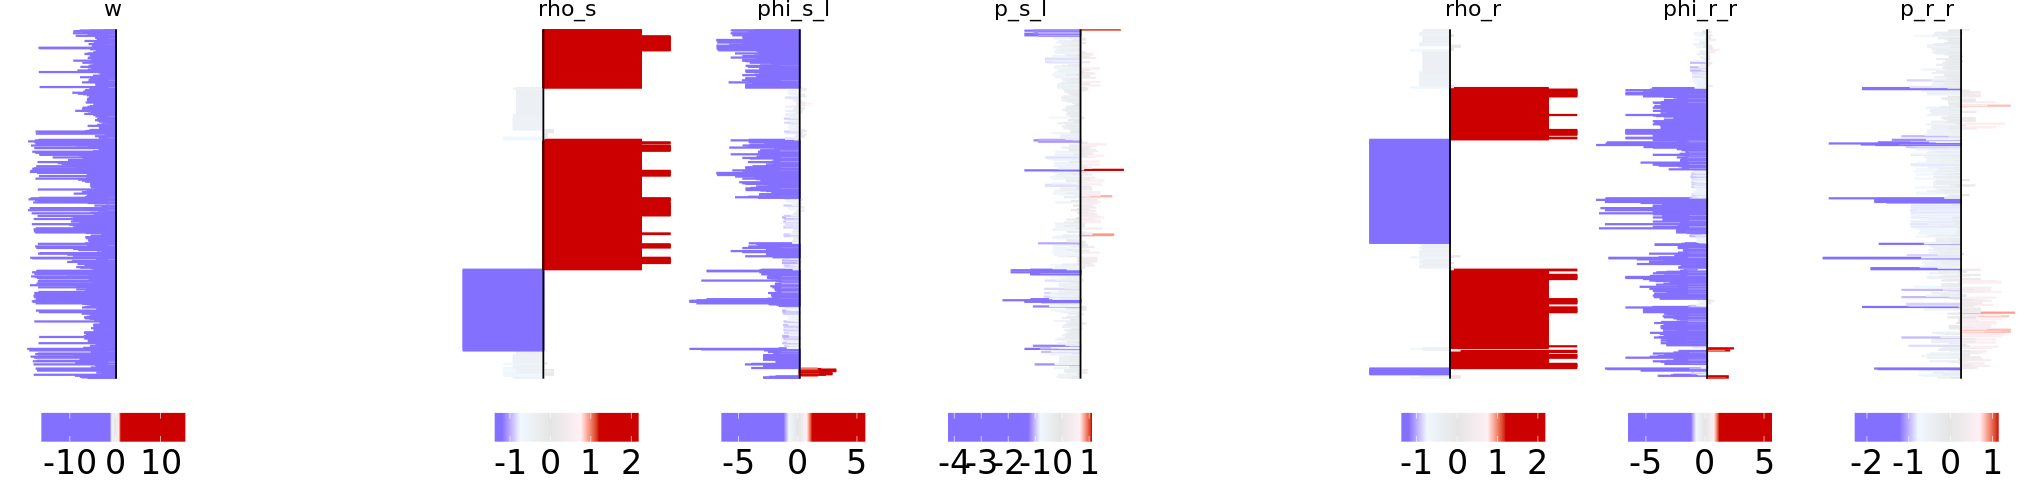

In [29]:
options(repr.plot.width = 17
       ,repr.plot.height = 4)

IDs <- as.character(c(ordered_IDs$ID_order_insuffDown_s
                          ,ordered_IDs$ID_order_insuffDown_r
                          ,ordered_IDs$ID_order_insuffDown_b
                     ))

forestplot_for_category(IDs)

[1] "20 interactions in this category"


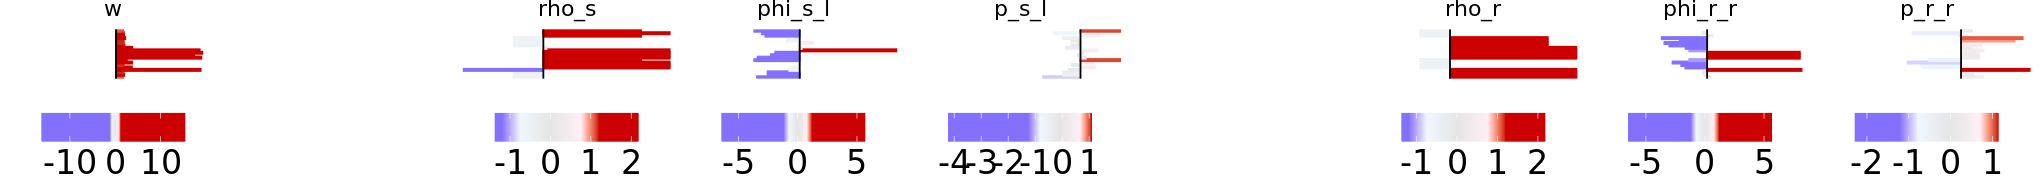

In [30]:
options(repr.plot.width = 17
       ,repr.plot.height = 1.5)

IDs <- as.character(c(ordered_IDs$ID_order_insuffUp_s
                          ,ordered_IDs$ID_order_insuffUp_r
                          ,ordered_IDs$ID_order_insuffUp_b
                     ))

forestplot_for_category(IDs)

[1] "1570 interactions in this category"


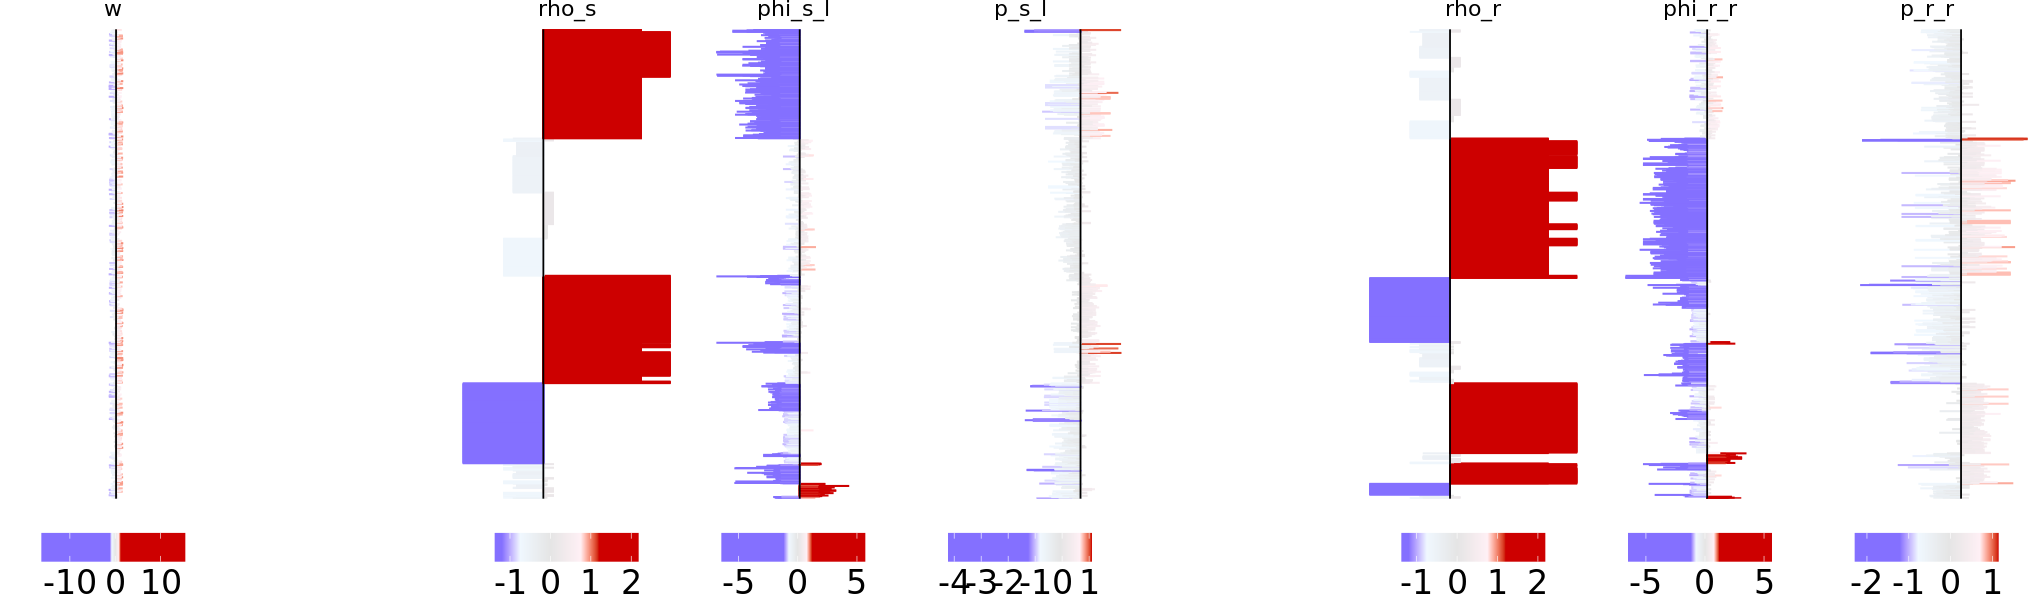

In [31]:
options(repr.plot.width = 17
       ,repr.plot.height = 5)

IDs <- as.character(c(ordered_IDs$ID_order_suffComp_s
                      ,ordered_IDs$ID_order_suffComp_r
                      ,ordered_IDs$ID_order_suffComp_b
                 ))

forestplot_for_category(IDs)

In [32]:
sessionInfo()

R version 4.1.2 (2021-11-01)
Platform: x86_64-conda-linux-gnu (64-bit)
Running under: CentOS Linux 7 (Core)

Matrix products: default
BLAS/LAPACK: /work/project/ladcol_011/conda_path/miniconda3/envs/community_paper/lib/libopenblasp-r0.3.26.so

locale:
 [1] LC_CTYPE=en_US.UTF-8       LC_NUMERIC=C              
 [3] LC_TIME=de_DE.UTF-8        LC_COLLATE=en_US.UTF-8    
 [5] LC_MONETARY=de_DE.UTF-8    LC_MESSAGES=en_US.UTF-8   
 [7] LC_PAPER=de_DE.UTF-8       LC_NAME=C                 
 [9] LC_ADDRESS=C               LC_TELEPHONE=C            
[11] LC_MEASUREMENT=de_DE.UTF-8 LC_IDENTIFICATION=C       

attached base packages:
[1] grid      stats     graphics  grDevices utils     datasets  methods  
[8] base     

other attached packages:
[1] gridExtra_2.3         igraph_1.6.0          circlize_0.4.15      
[4] ComplexHeatmap_2.10.0 ggrepel_0.9.5         ggplot2_3.4.4        
[7] community_1.4.1      

loaded via a namespace (and not attached):
  [1] readxl_1.4.3                uuid_1.1-0 